In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import time
from catboost import Pool
from catboost import CatBoostRegressor
from omegaconf import OmegaConf
from scipy.stats import norm
from nba_betting_ai.consts import proj_paths
from nba_betting_ai.model.inputs import prepare_scalers
from nba_betting_ai.training.catboost import data_pipeline_cb
from nba_betting_ai.training.pipeline import prepare_data

In [10]:
now = time.strftime("%Y%m%d-%H%M%S")
config = OmegaConf.load(proj_paths.config.default)
scalers_path = proj_paths.output / f'scalers-{now}-cat.pkl'
input_teams = config['inputs_team'] or []
data_prepared = prepare_data(**config.data_params)
scalers = prepare_scalers(data_prepared.X_train, input_teams, scalers_path)

In [25]:
team_encoder = dict(zip(data_prepared.teams['abbreviation'], data_prepared.teams.index))

include_teams = config.get('include_teams', False)
X_train, y_train = data_pipeline_cb(data_prepared.X_train, scalers, input_teams, team_encoder, include_teams, config['target'])
X_test, y_test = data_pipeline_cb(data_prepared.X_test, scalers, input_teams, team_encoder, include_teams, config['target'])
cat_features = ['home_team', 'away_team'] if include_teams else []

train_dir = proj_paths.output / 'catboost' / now
train_dir.mkdir(parents=True, exist_ok=True)

pool_train = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)
pool_test = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

In [28]:
model = CatBoostRegressor(**config.training.params, train_dir=train_dir)
report = model.fit(pool_test, eval_set=pool_test, verbose=100)

0:	learn: -0.0310636	test: -0.0310636	best: -0.0310636 (0)	total: 1.46ms	remaining: 2.92s
100:	learn: -0.4296868	test: -0.4296868	best: -0.4296868 (100)	total: 141ms	remaining: 2.65s
200:	learn: -0.6600481	test: -0.6600481	best: -0.6600481 (200)	total: 285ms	remaining: 2.55s
300:	learn: -0.8192364	test: -0.8192364	best: -0.8192364 (300)	total: 437ms	remaining: 2.47s
400:	learn: -0.9340962	test: -0.9340962	best: -0.9340962 (400)	total: 592ms	remaining: 2.36s
500:	learn: -1.0226500	test: -1.0226500	best: -1.0226500 (500)	total: 746ms	remaining: 2.23s
600:	learn: -1.1036777	test: -1.1036777	best: -1.1036777 (600)	total: 918ms	remaining: 2.13s
700:	learn: -1.1724137	test: -1.1724137	best: -1.1724137 (700)	total: 1.07s	remaining: 1.99s
800:	learn: -1.2390240	test: -1.2390240	best: -1.2390240 (800)	total: 1.23s	remaining: 1.84s
900:	learn: -1.3013081	test: -1.3013081	best: -1.3013081 (900)	total: 1.39s	remaining: 1.69s
1000:	learn: -1.3598252	test: -1.3598252	best: -1.3598252 (1000)	total: 1

In [31]:
y_true_train = y_train['final_score_diff'] > 0.5
preds = model.predict(X_train)
mean, _ = preds[:,0], preds[:,1]
y_pred_train = mean > 0.5
accuracy_train = np.mean(y_true_train == y_pred_train)
print(f'Train accuracy: {accuracy_train}')

Train accuracy: 0.7368844956983343


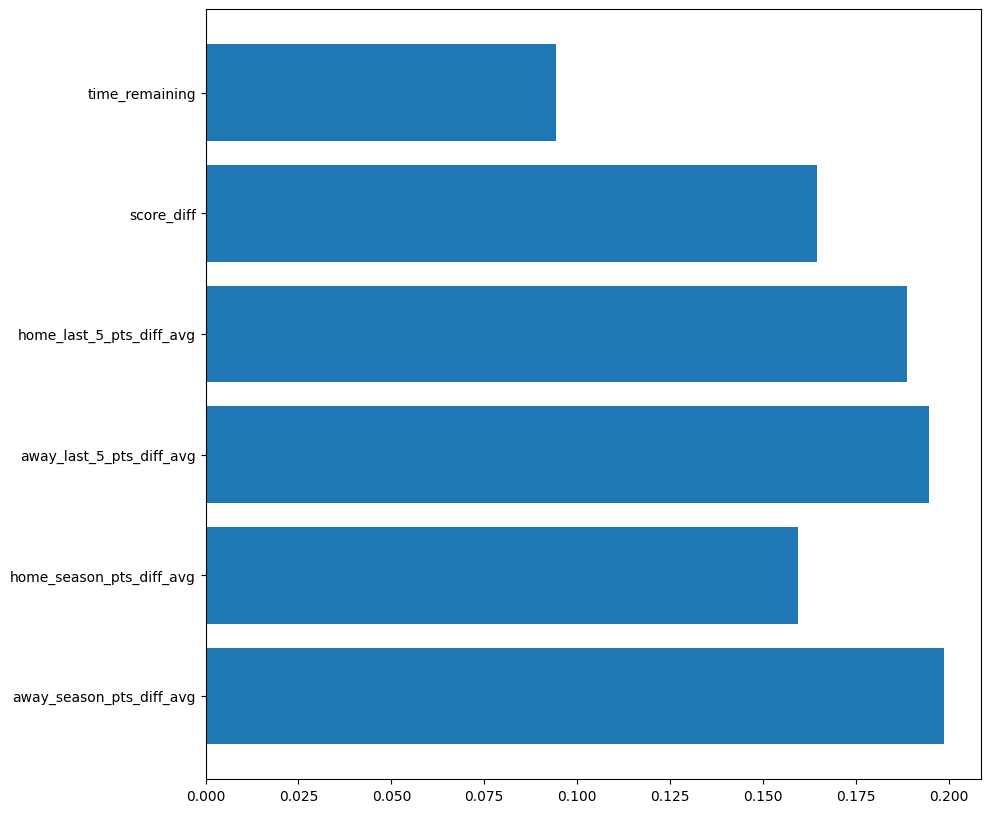

In [13]:
feature_importance = model.get_feature_importance()
feature_importance = feature_importance / feature_importance.sum()
feature_importance = pd.Series(feature_importance, index=X_train.columns)
feature_importance.sort_values(ascending=False) * 100

plt.figure(figsize=(10, 10))
plt.barh(feature_importance.index, feature_importance)
plt.show()

Test accuracy: 0.9326923076923077


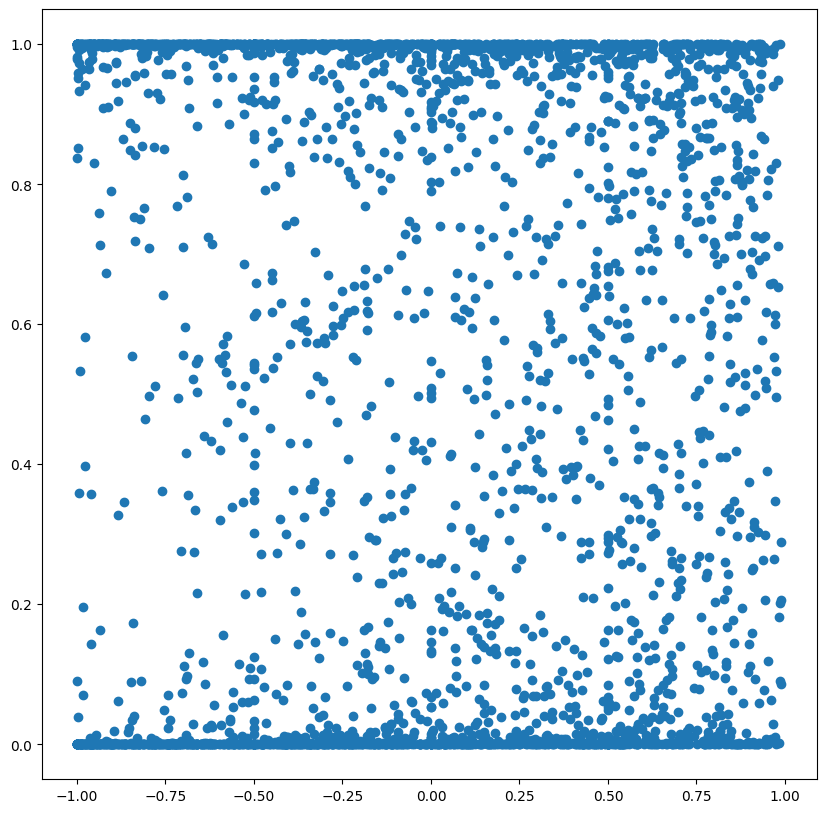

In [32]:
pool = Pool(
    data=X_test,
    cat_features=cat_features
)
preds = model.predict(pool)
mean, var_preds = preds[:,0], preds[:,1]
std = np.sqrt(var_preds)
prob = norm.cdf(0, mean - 0.5, std)

y_true_test = y_test['final_score_diff'] > 0.5
y_pred_test = mean > 0.5
accuracy_test = np.mean(y_true_test == y_pred_test)
print(f'Test accuracy: {accuracy_test}')

probs = pd.Series(prob, index=X_test.time_remaining)
plt.figure(figsize=(10, 10))
# plt.scatter(probs, y_test)
probs_time = probs.sort_index()
y = pd.Series(y_test.final_score_diff > 0, index=X_test.time_remaining).sort_index()
plt.scatter(probs_time.index, probs_time)#, c=y)

In [15]:
config_path = proj_paths.models / f'run_config-{now}-cat.yaml'
config_path.open("w").write(OmegaConf.to_yaml(config))
model_path = proj_paths.models / f'cb_model-{now}-cat.cbm'
model.save_model(model_path)
shutil.copyfile(scalers_path, proj_paths.models / f'scalers-{now}-cat.pkl')
print(model_path)

/workspaces/nba-betting-ai/models/cb_model-20250212-163502-cat.cbm
